# Лабораторная работа №1. Регрессия

**Тема:** *Сравнение линейной регрессии, случайного леса (Random Forest Regressor), градиентного бустинга (XGBoost) на задаче регрессии.*

**Цели:**

- *Научиться строить, оптимизировать и оценивать регрессионные модели.*
- *Понять, как интерпретировать важность признаков (feature importance).*
- *Понять, как увеличивать кол-во признаков (feature tuning).*
- *Исследовать влияние преобразований признаков (фичей), регуляризации и гиперпараметров.*

**Условия:**

- *numpy, pandas, scikit-learn, XGBoost*
- *выбрать датасет для 1-ой и 2-ой лабораторной работы*

**Пункты:**

1. Подготовка данных + Feature Tuning
2. Создание метрик
3. Базовая модель линейной регрессии
4. Улучшение линейной регрессии
5. Случайный лес регрессор
6. Градиентный бустинг (XGBoost)
7. Feature Importance
8. Написание своих реализаций (классы)
9. Подведение итогов


## О командe

| Фамилия И.О.        | Группа | Роль в команде | Что делал                    |
|---------------------|--------|----------------|------------------------------|
| Усов С.Е.         | 307    | Solo way       | Все сам                      |

 Датасет: [abalone](https://code.datasciencedojo.com/zhangyuan/datasets/tree/master/Abalone)

## Описание датасета

Этот набор данных содержит физические измерения морских улиток — абалонов — и используется для предсказания их возраста. Возраст определяется по количеству колец на раковине, что требует разрезания, окрашивания и подсчёта под микроскопом — трудоёмкая и скучная процедура. Цель задачи — научиться предсказывать возраст (количество колец) по более легко измеримым физическим характеристикам, таким как размеры и веса.

Данные отлично подходят для практики в разведочном анализе (EDA), визуализации, а также в построении моделей классификации и регрессии. Несмотря на кажущуюся простоту, задача может оказаться нетривиальной из-за нелинейных зависимостей, асимметричного распределения возраста и категориального признака пола.

---

### Таблица признаков датасета "Abalone"

| № | Признак | Тип данных | Описание |
|---|---|---|---|
| 1 | **Sex** | categorical | Пол абалона (M: самец, F: самка, I: детеныш) |
| 2 | **Length** | float | Длина раковины (наибольшее измерение в мм) |
| 3 | **Diameter** | float | Диаметр раковины (перпендикулярно длине в мм) |
| 4 | **Height** | float | Высота раковины (с мясом внутри в мм) |
| 5 | **Whole weight** | float | Общий вес абалона (в граммах) |
| 6 | **Shucked weight** | float | Вес мяса без раковины (в граммах) |
| 7 | **Viscera weight** | float | Вес внутренностей после очистки (в граммах) |
| 8 | **Shell weight** | float | Вес высушенной раковины (в граммах) |
| 9 | **Rings** (target) | integer | Количество колец на раковине (возраст = кольца + 1.5 года) |


## 0. Глобальная настройка проекта


In [517]:
RND_SEED = 21
USE_AUTO_POLY = True

## 1. Подготовка данных + Feature Tuning

### 1.1. Загрузка датасета

Подключим библиотеки, для предобработки данных

In [518]:
import pandas as pd
import numpy as np

Загрузка датасета `pd.read_csv(path_to_dataset: str)`

In [519]:
column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
                'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']

file_path = 'abalone.csv'

df = pd.read_csv(file_path, names=column_names, header=0)

Посмотрим первые три строки датасета `df.head(n: int)`

In [520]:
df.head(3)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.35,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.53,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.44,0.365,0.125,0.5160,0.2155,0.1140,0.155,10


Атрибут sex (пол): Этот признак имеет текстовые категориальные значения (M, F, I). Большинство алгоритмов машинного обучения работают только с числами, поэтому этот столбец нельзя использовать в исходном виде `Sex`. Преобразовать в числовой формат методом one-hot encoding (создание отдельных столбцов для каждой категории).

In [521]:
sex_encoded = pd.get_dummies(df['Sex'], prefix='Sex', dtype=int)
df_encoded = pd.concat([df.drop('Sex', axis=1), sex_encoded], axis=1)

for col in ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']:
    df_encoded[col] = pd.to_numeric(df_encoded[col], errors='coerce')

df_encoded = df_encoded.drop(df_encoded[df_encoded['Length'].isnull()].index)

In [522]:
print("Данные после one-hot encoding:")
df_encoded.head(3)

Данные после one-hot encoding:


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.35,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
1,0.53,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
2,0.44,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1


### 1.2. Сбор основной информации

Получение общей информации `df_encoded.info()`

In [523]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          4176 non-null   float64
 1   Diameter        4176 non-null   float64
 2   Height          4176 non-null   float64
 3   Whole weight    4176 non-null   float64
 4   Shucked weight  4176 non-null   float64
 5   Viscera weight  4176 non-null   float64
 6   Shell weight    4176 non-null   float64
 7   Rings           4176 non-null   int64  
 8   Sex_F           4176 non-null   int64  
 9   Sex_I           4176 non-null   int64  
 10  Sex_M           4176 non-null   int64  
dtypes: float64(7), int64(4)
memory usage: 359.0 KB


Получение всей статистики `df_encoded.describe()`

In [524]:
df_encoded.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
count,4176.000000,4176.000000,4176.000000,4176.000000,4176.00000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000
mean,0.524009,0.407892,0.139527,0.828818,0.35940,0.180613,0.238852,9.932471,0.312979,0.321360,0.365661
std,0.120103,0.099250,0.041826,0.490424,0.22198,0.109620,0.139213,3.223601,0.463761,0.467055,0.481673
min,0.075000,0.055000,0.000000,0.002000,0.00100,0.000500,0.001500,1.000000,0.000000,0.000000,0.000000
25%,0.450000,0.350000,0.115000,0.441500,0.18600,0.093375,0.130000,8.000000,0.000000,0.000000,0.000000
50%,0.545000,0.425000,0.140000,0.799750,0.33600,0.171000,0.234000,9.000000,0.000000,0.000000,0.000000
75%,0.615000,0.480000,0.165000,1.153250,0.50200,0.253000,0.329000,11.000000,1.000000,1.000000,1.000000
max,0.815000,0.650000,1.130000,2.825500,1.48800,0.760000,1.005000,29.000000,1.000000,1.000000,1.000000


**Вывод:**

1. **Общая информация**

    * **Размер датасета**: 4177 наблюдений (морских улиток).
    * **Целевая переменная (Rings)**: принимает значения от **1 до 29**, со средним ≈ **9.93**.
    
        -> Возраст улиток варьируется от 1 года (молодые особи) до 29 лет (старые), но большинство улиток имеют возраст **8–11 лет** (25%–75% перцентили).
        -> Распределение возраста симметричное (медиана 9.0), стандартное отклонение 3.22 — улитки в основном не слишком молодые и не очень старые.

2. **Размеры тела**

    * **Length (длина)**:
        * Среднее ≈ 0.52, разброс значительный (от 0.075 до 0.815).
        * Большинство улиток имеют длину в диапазоне **0.45–0.615** (25%–75% перцентили).
        * Минимальное значение (0.075) соответствует очень молодым особям, максимальное (0.815) — крупным взрослым.

    * **Diameter (диаметр)**:
        * Среднее ≈ 0.408, минимальное 0.055, максимальное 0.65.
        * Основная масса улиток имеет диаметр **0.35–0.48** (25%–75% перцентили).
        * Соотношение длины к диаметру ≈ 1.3:1 — типично для раковин моллюсков.

    * **Height (высота)**:
        * Среднее ≈ 0.14, но **максимальное значение 1.13 — аномально высокое** (в 8 раз больше медианы 0.14).
        * Минимальное значение **0 — физически невозможно** для живой улитки (вероятно, ошибка в данных или незаполненные значения).
        * Большинство улиток имеют высоту **0.115–0.165**, но есть экстремальные выбросы, требующие проверки.

3. **Весовые характеристики**

    * **Whole weight (общий вес)**:
        * Среднее ≈ 0.83, стандартное отклонение 0.49 — сильный разброс.
        * Минимальное значение **0.002** (микроскопические особи) vs максимальное **2.8255** (крупные улитки).
        * Большинство улиток весят **0.44–1.15** — вес коррелирует с возрастом (Rings), но есть редкие экземпляры с аномально высоким весом.

    * **Shell weight (вес раковины)**:
        * Среднее ≈ 0.24, медиана 0.234 — раковина составляет ~25% от общего веса.
        * Вес раковины в основном **0.13–0.33**, что соответствует здоровому росту. Высокие значения (>0.5) могут указывать на старые особи.

    * **Shucked weight (вес мяса)** и **Viscera weight (вес внутренностей)**:
        * Мясо составляет ~43% от общего веса (Shucked weight среднее 0.36), внутренности — ~22% (Viscera weight среднее 0.18).
        * Соотношение мяса к внутренностям ≈ 2:1 — типично для моллюсков. Высокие значения Viscera weight (>0.5) могут быть связаны с размножением.

4. **Пол (Sex)**

    * **Распределение по полу**:
        * **Sex_M (мужские)**: 36.6% (среднее 0.366) — наиболее распространенная категория.
        * **Sex_I (неопределенные)**: 32.1% (среднее 0.321) — молодые особи, пол еще не определен.
        * **Sex_F (женские)**: 31.3% (среднее 0.313) — немного реже мужских.
    
    * **Вывод**: Пол распределен почти равномерно, что важно для анализа (нет дисбаланса). Неопределенные особи (Sex_I) составляют треть датасета — возможно, это данные о молодых улитках до полового созревания.

Проверка на пропуски данных `df_encoded.isnull().sum()`

In [525]:
print(df_encoded.isnull().sum())

Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
Sex_F             0
Sex_I             0
Sex_M             0
dtype: int64


**Вывод:** в датасете нет пропусков!

Посмотрим на распределение целевой переменной

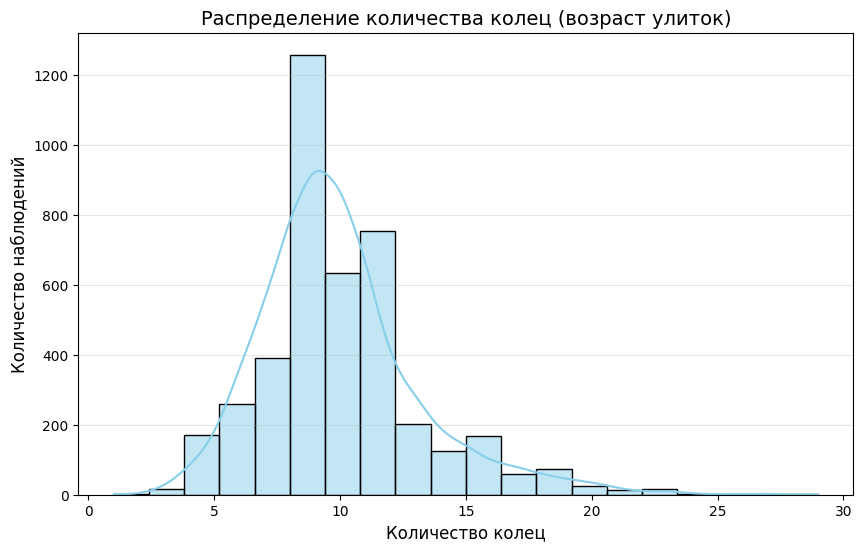

In [526]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_encoded,
    x='Rings',
    kde=True,
    bins=20,
    color='skyblue'
)
plt.title('Распределение количества колец (возраст улиток)', fontsize=14)
plt.xlabel('Количество колец', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

**Вывод:**

Размер датасета: 4177 наблюдений (морских улиток).        
Целевая переменная (Rings): принимает значения от 1 до 29, со средним ≈ 9.93.
-> Возраст улиток в основном сосредоточен в диапазоне 8–11 лет (25%–75% перцентили), медиана = 9.0.
-> Распределение симметричное и сбалансированное — нет значительного перекоса в сторону молодых или старых особей. Это идеально для задач регрессии, так как все возрастные группы представлены достаточно равномерно.
         
     

Посмотрим на корреляцию данных.

***Определение 1: Корреляция данных — это статистическая мера, показывающая, насколько и в каком направлении связаны между собой две переменные.***

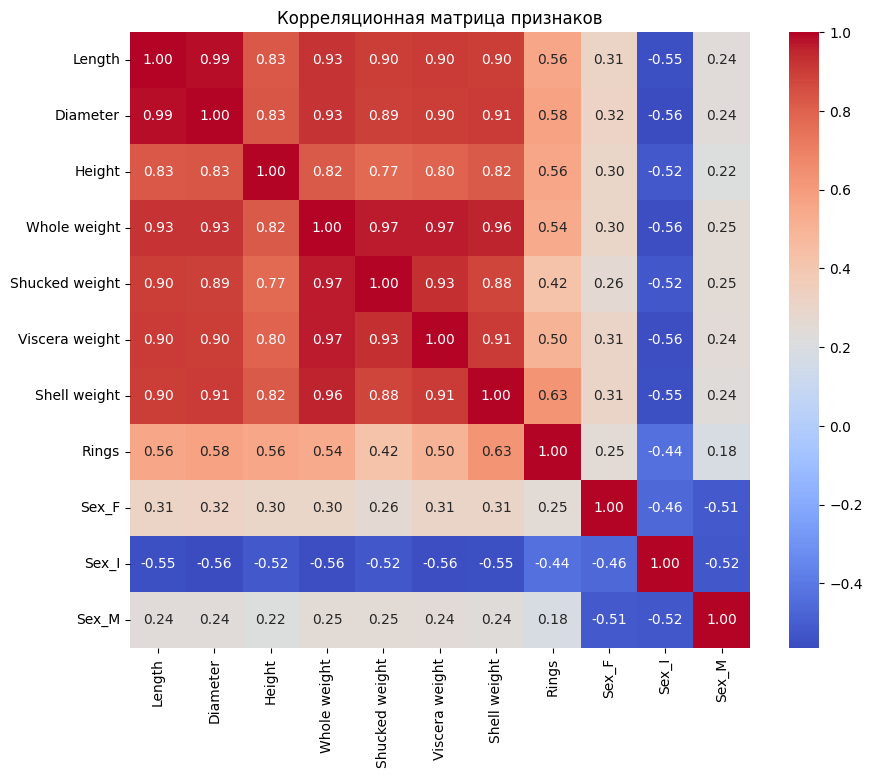

In [527]:
def draw_corr_matrix(df):
    plt.figure(figsize=(10,8))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Корреляционная матрица признаков")
    plt.show()

draw_corr_matrix(df_encoded)

**Анализ корреляционной матрицы:**

1. **Сильные положительные корреляции**  
   - **Размеры тела**:  
     `Length` ↔ `Diameter` (**0.99**), `Length` ↔ `Whole weight` (**0.93**), `Diameter` ↔ `Whole weight` (**0.93**) — улитки с большими размерами имеют больший общий вес.  
     Это логично: рост улитки пропорционален увеличению всех её параметров.  

   - **Весовые характеристики**:  
     `Whole weight` ↔ `Shucked weight` (**0.97**), `Shell weight` ↔ `Whole weight` (**0.96**) — общая масса улитки зависит от веса мяса (`Shucked weight`) и раковины (`Shell weight`).  

2. **Корреляции с целевой переменной (Rings)**  
   - **Наибольшая связь**:  
     `Shell weight` ↔ `Rings` (**0.63**) — чем старше улитка, тем тяжелее её раковина. Это ключевой признак для предсказания возраста.  
     `Whole weight` ↔ `Rings` (**0.56**) — общий вес также растёт с возрастом, но медленнее, чем вес раковины.  

   - **Слабые связи**:  
     `Viscera weight` ↔ `Rings` (**0.45**) — внутренние органы растут, но не пропорционально возрасту.  
     `Sex_*` ↔ `Rings` (**−0.44 до −0.52**) — женские и молодые улитки (`Sex_F`, `Sex_I`) чаще встречаются в более молодых возрастных группах.  

3. **Мультиколлинеарность**  
   - **Размеры тела**:  
     `Length`, `Diameter`, `Height` коррелируют выше **0.8** — их использование вместе в линейных моделях приведёт к нестабильности коэффициентов.

   - **Весовые признаки**:  
     `Whole weight` ↔ `Shucked weight` (**0.97**) — информация дублируется.  

4. **Отрицательные корреляции**  
   - `Sex_M` ↔ `Sex_F` (**−0.56**), `Sex_I` ↔ `Sex_M` (**−0.52**) — улитки не могут быть одновременно мужскими и женскими/иммартурными.

---

- **Основные признаки для модели линейной регрессии**: `Shell weight`, `Length`.  

### 1.3. Подготовка датасета под разные задачи

#### 1.3.1 Линейная регрессия (Linear Regression / Ridge / Lasso)

**Особенности модели:**

- Чувствительна к масштабу признаков и мультиколлинеарности.
- Чувствительна к выбросам.

Разделение датасета на свойства и целевую переменную

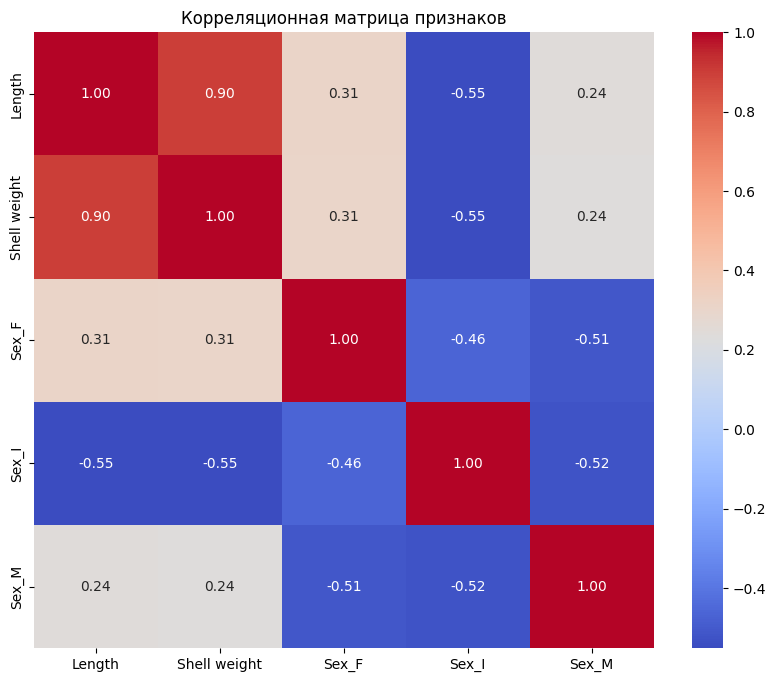

In [528]:
selected_features = ['Length', 'Shell weight', 'Sex_F', 'Sex_I', 'Sex_M']
X_linear = df_encoded[selected_features]
Y_linear = df_encoded['Rings']

draw_corr_matrix(X_linear)

Здесь довольно большая корреляция между Length и Shell Weight, но это нормально, поскольку они отражают важные физические характеристики.

Добавим функцию проверки на выбросы данных.

In [529]:
def check_outliers(df, columns=None, title=""):
    if columns is None:
        columns = df.select_dtypes(include='number').columns

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        print(f"\n{title}{col}: {len(outliers)} выбросов ({len(outliers)/len(df)*100:.1f}%)")
        print(f"Границы: [{lower_bound:.4f}, {upper_bound:.4f}]")

        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col])
        plt.title(f'{col} | Выбросы: {len(outliers)}')
        plt.show()

Визуализируем целевую переменную - Y и набор свойств - X. Также подготовим заранее разделение на Train/Test. Скошенность бинарных данных - пол, не требует дальнейшей трансформации.

In [530]:
from sklearn.model_selection import train_test_split

skew_values_X_linear = X_linear.skew()
skew_values_hard = skew_values_X_linear[abs(skew_values_X_linear) > 0.5]
print(skew_values_hard)

skew_columns_hard = list(skew_values_hard.index)
print(f'Скошенные столбцы Свойств: {skew_columns_hard}')

y_skew = Y_linear.skew()
print(f"\nСкошенность целевой переменной (Rings): {y_skew:.4f}")
if abs(y_skew) > 0.5:
    print("Целевая переменная сильно скошена!")
else:
    print("Целевая переменная не сильно скошена!")

X_linear_train, X_linear_test, Y_linear_train, Y_linear_test = train_test_split(
    X_linear, Y_linear, test_size=0.2, random_state=RND_SEED)

Length         -0.640240
Shell weight    0.620547
Sex_F           0.806927
Sex_I           0.765330
Sex_M           0.558070
dtype: float64
Скошенные столбцы Свойств: ['Length', 'Shell weight', 'Sex_F', 'Sex_I', 'Sex_M']

Скошенность целевой переменной (Rings): 1.1152
Целевая переменная сильно скошена!


Проверим X_linear_train и Y_linear_train на выбросы.


X_linear_train (до): Length: 37 выбросов (1.1%)
Границы: [0.2025, 0.8625]


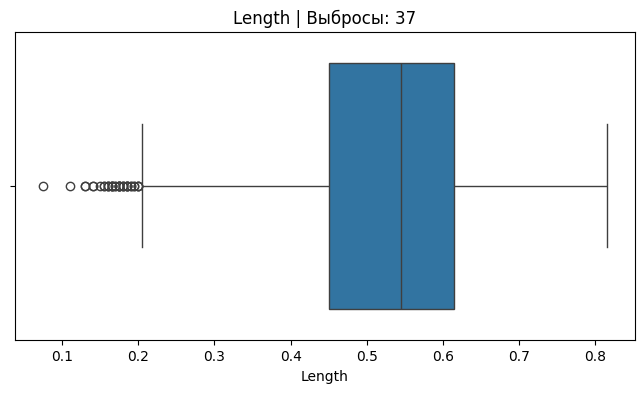


X_linear_train (до): Shell weight: 28 выбросов (0.8%)
Границы: [-0.1678, 0.6262]


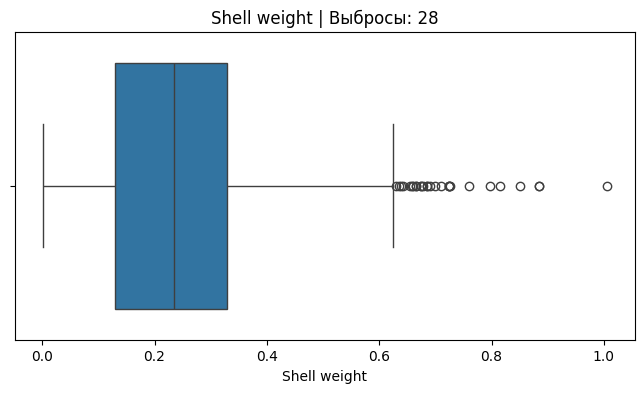


X_linear_train (до): Sex_F: 0 выбросов (0.0%)
Границы: [-1.5000, 2.5000]


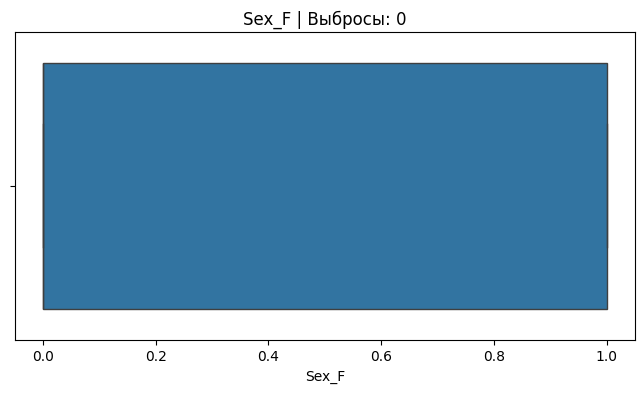


X_linear_train (до): Sex_I: 0 выбросов (0.0%)
Границы: [-1.5000, 2.5000]


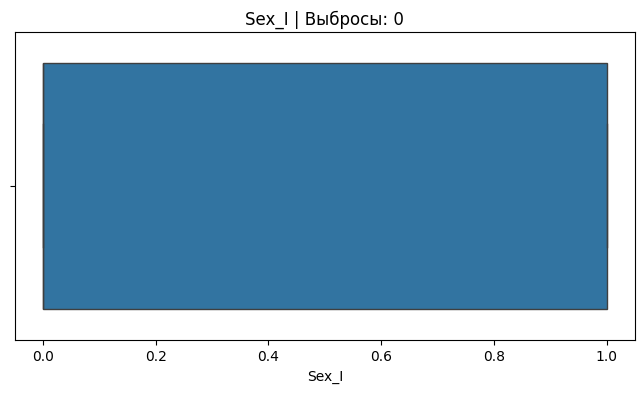


X_linear_train (до): Sex_M: 0 выбросов (0.0%)
Границы: [-1.5000, 2.5000]


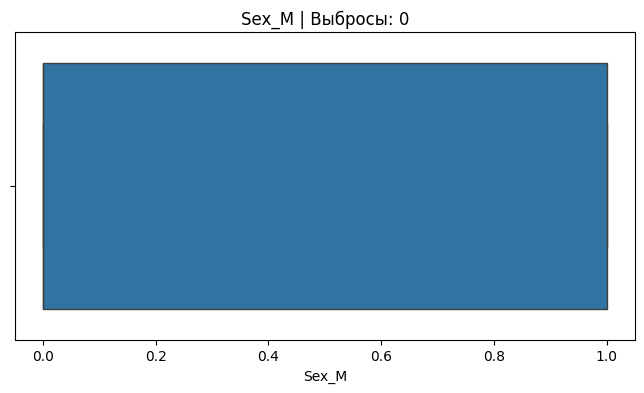


Y_linear_train (до): Rings: 212 выбросов (6.3%)
Границы: [3.5000, 15.5000]


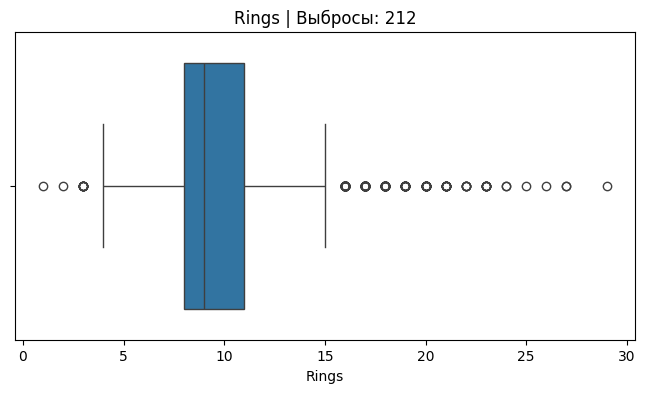

In [531]:
check_outliers(X_linear_train, title="X_linear_train (до): ")

check_outliers(pd.DataFrame(Y_linear_train, columns=['Rings']), title="Y_linear_train (до): ")

Исправим данные для свойства - Shell Weight и целевой переменной Rings. Править для других не имеет смысла, поскольку процент очень незначителен от общего числа.

In [532]:
X_linear_train['Shell weight'] = X_linear_train['Shell weight'].apply(lambda x: 0 if x < 0 else x)

mask = Y_linear_train >= 3.5

X_linear_train = X_linear_train.loc[mask]
Y_linear_train = Y_linear_train[mask]

Трансформация целевой переменной Y.

In [533]:
from sklearn.preprocessing import PowerTransformer

pt_y_linear = PowerTransformer(method='yeo-johnson')
y_linear_train_transformed = pt_y_linear.fit_transform(Y_linear_train.values.reshape(-1, 1)).flatten()
y_linear_test_transformed = pt_y_linear.transform(Y_linear_test.values.reshape(-1, 1)).flatten()

Проверка целевой переменной Y после трансформации.


Скошенность Y после трансформации:
Train: -0.0048
Test:  -0.3231


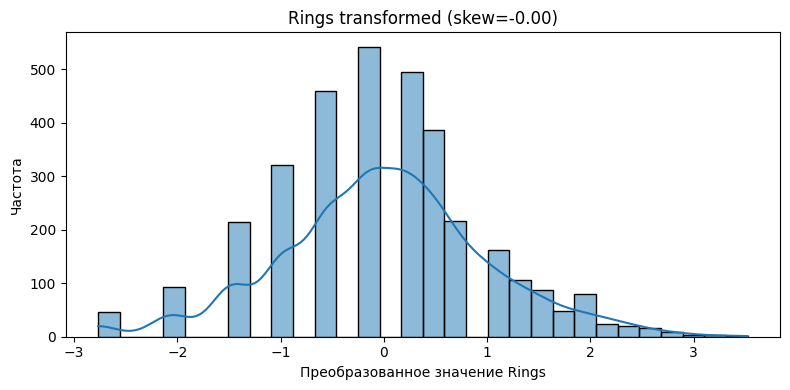

In [534]:
print("\nСкошенность Y после трансформации:")
print(f"Train: {pd.Series(y_linear_train_transformed).skew():.4f}")
print(f"Test:  {pd.Series(y_linear_test_transformed).skew():.4f}")

plt.figure(figsize=(8, 4))
sns.histplot(y_linear_train_transformed, kde=True, bins=30)
plt.title(f'Rings transformed (skew={pd.Series(y_linear_train_transformed).skew():.2f})')
plt.xlabel('Преобразованное значение Rings')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

Теперь скошенность находится в хорошем состоянии. Нет явных выбросов.


Трансформация свойств - X.

In [535]:
from sklearn.preprocessing import StandardScaler

transform_features = ['Length', 'Shell weight']

X_train_transform = X_linear_train[transform_features]
X_test_transform = X_linear_test[transform_features]

pt_X_linear = PowerTransformer(method='yeo-johnson')
X_train_transformed = pt_X_linear.fit_transform(X_train_transform)
X_test_transformed = pt_X_linear.transform(X_test_transform)

X_linear_train_transformed = pd.DataFrame(
    X_train_transformed,
    columns=transform_features,
    index=X_linear_train.index
)
X_linear_test_transformed = pd.DataFrame(
    X_test_transformed,
    columns=transform_features,
    index=X_linear_test.index
)

X_linear_train_transformed = pd.concat([
    X_linear_train_transformed,
    X_linear_train.drop(columns=transform_features)
], axis=1)

X_linear_test_transformed = pd.concat([
    X_linear_test_transformed,
    X_linear_test.drop(columns=transform_features)
], axis=1)

scaler = StandardScaler()
X_linear_train_scaled = scaler.fit_transform(X_linear_train_transformed)
X_linear_test_scaled = scaler.transform(X_linear_test_transformed)

Проверка свойств X после трансформации.

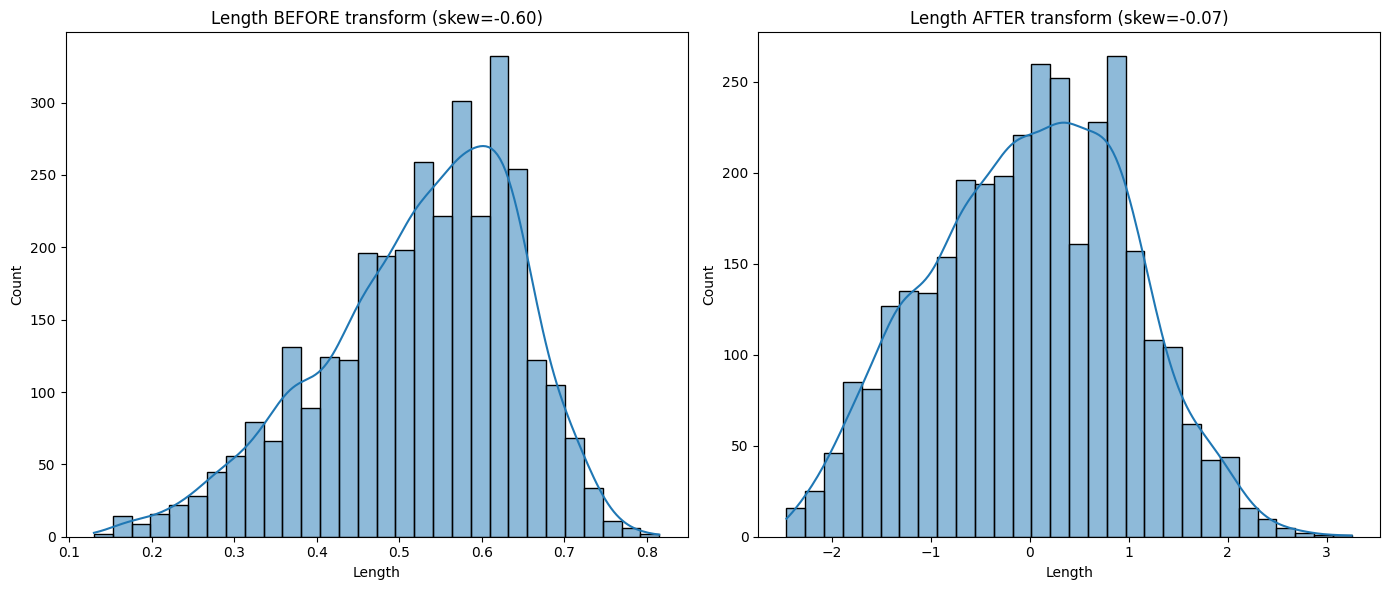

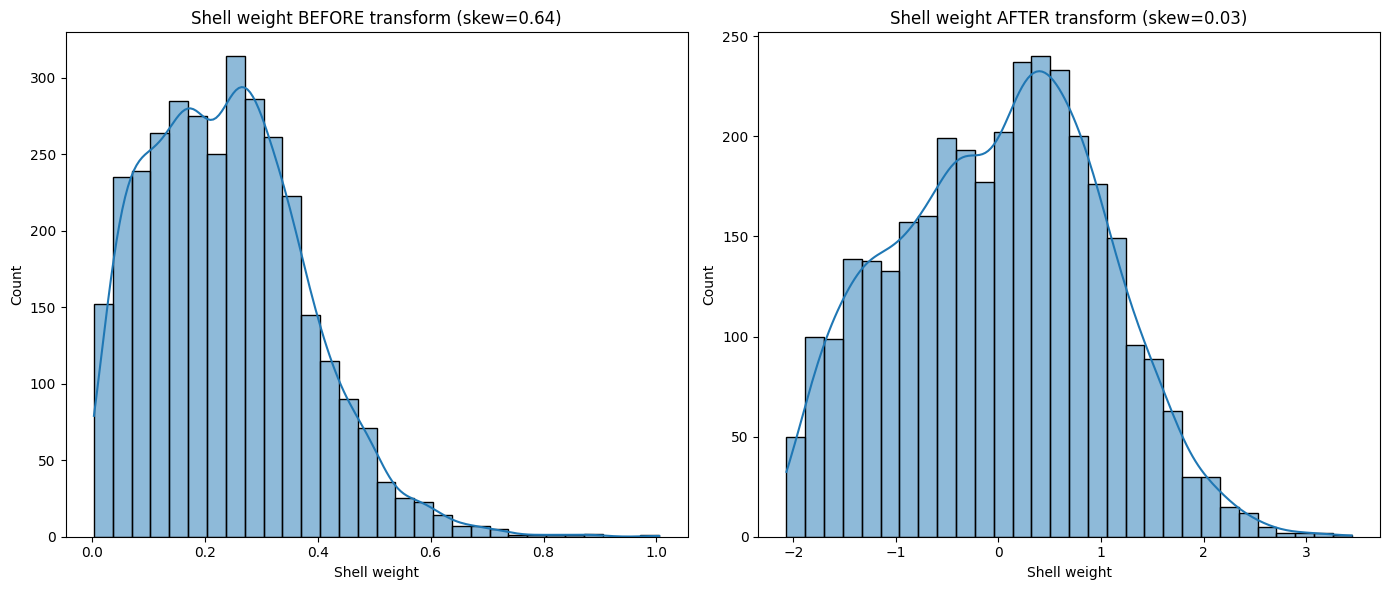


X_linear_train (после): Length: 2 выбросов (0.1%)
Границы: [-2.9444, 2.9599]


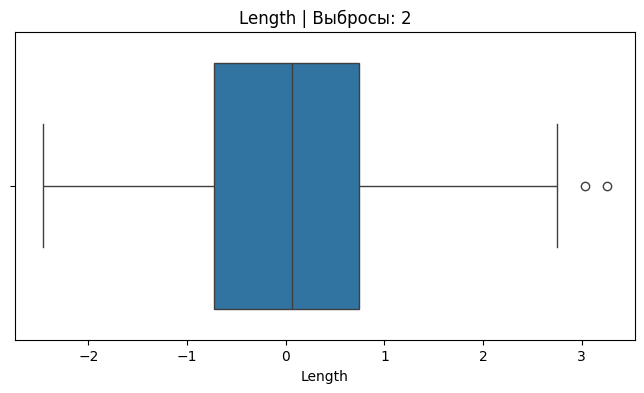


X_linear_train (после): Shell weight: 4 выбросов (0.1%)
Границы: [-3.0261, 2.9962]


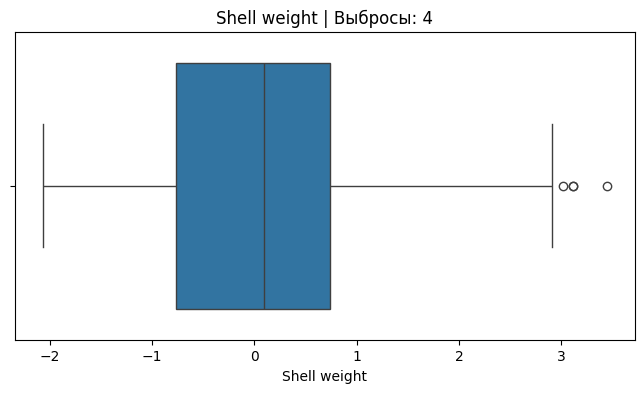


X_linear_train (после): Sex_F: 0 выбросов (0.0%)
Границы: [-1.5000, 2.5000]


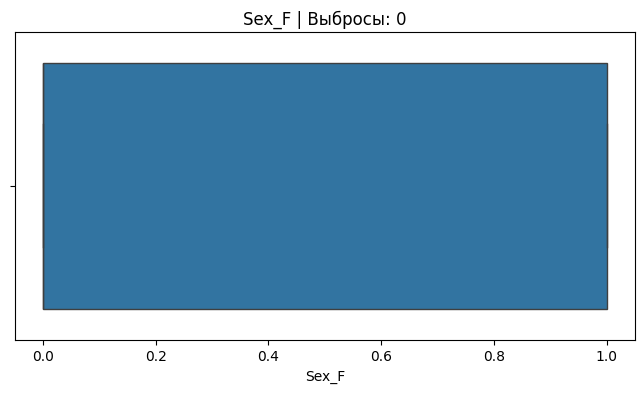


X_linear_train (после): Sex_I: 0 выбросов (0.0%)
Границы: [-1.5000, 2.5000]


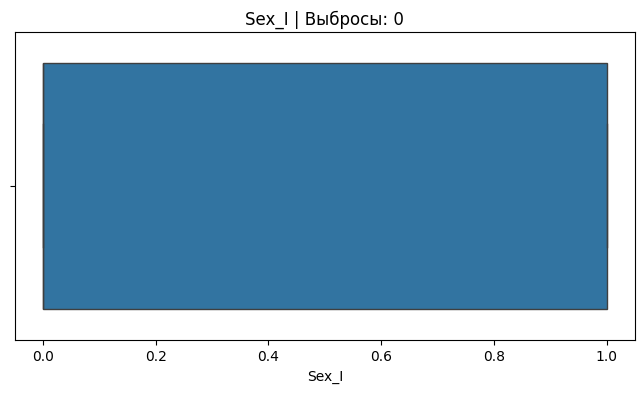


X_linear_train (после): Sex_M: 0 выбросов (0.0%)
Границы: [-1.5000, 2.5000]


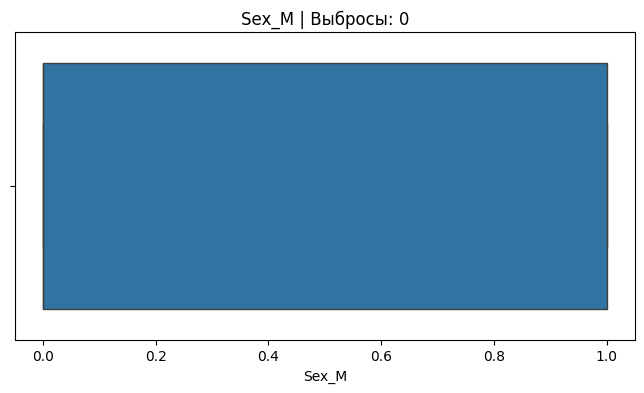

In [536]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(X_linear_train['Length'], kde=True, bins=30)
plt.title(f'Length BEFORE transform (skew={X_linear_train["Length"].skew():.2f})')

plt.subplot(1, 2, 2)
sns.histplot(X_linear_train_transformed['Length'], kde=True, bins=30)
plt.title(f'Length AFTER transform (skew={X_linear_train_transformed["Length"].skew():.2f})')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(X_linear_train['Shell weight'], kde=True, bins=30)
plt.title(f'Shell weight BEFORE transform (skew={X_linear_train["Shell weight"].skew():.2f})')

plt.subplot(1, 2, 2)
sns.histplot(X_linear_train_transformed['Shell weight'], kde=True, bins=30)
plt.title(f'Shell weight AFTER transform (skew={X_linear_train_transformed["Shell weight"].skew():.2f})')
plt.tight_layout()
plt.show()

check_outliers(X_linear_train_transformed, title="X_linear_train (после): ")

#### 1.3.2 Random Forest Regressor

**Особенности модели:**

* Не чувствительна к масштабу признаков.
* Может обрабатывать сильные корреляции между признаками.
* Может использовать категориальные признаки, если они закодированы как числовые.


Сделаем копию датасета

In [537]:
df_forest = df_encoded.copy()

Feature engineering

In [538]:
df_forest['shell_ratio'] = df_forest['Shell weight'] / df_forest['Whole weight']
df_forest['viscera_to_shucked'] = df_forest['Viscera weight'] / df_forest['Shucked weight']

df_forest['density'] = df_forest['Whole weight'] / (
    df_forest['Length'] * df_forest['Diameter'] * df_forest['Height']
).replace(0, np.nan)
df_forest['density'] = df_forest['density'].fillna(0)

df_forest = df_forest.drop(columns=[
    'Shell weight',
    'Whole weight',
    'Viscera weight',
    'Shucked weight',
    'Length',
    'Diameter',
    'Height'
])

Разделение выборки

In [539]:
from sklearn.model_selection import train_test_split

X_forest = df_forest.drop(columns=['Rings'])
y_forest = df_forest['Rings']

X_forest_train, X_forest_test, y_forest_train, y_forest_test = train_test_split(
    X_forest, y_forest,
    test_size=0.2,
    random_state=RND_SEED
)

#### 1.3.3 XGBoost

**Особенности модели:**

* Градиентный бустинг деревьев.
* Не чувствителен к масштабу.
* Может обрабатывать коррелированные признаки, но слишком много слабых признаков может замедлить обучение.

Сделаем копию датасета

In [540]:
df_xgboost = df_encoded.copy()

Feature engineering

In [541]:
df_xgboost['shell_ratio'] = df_xgboost['Shell weight'] / df_xgboost['Whole weight']
df_xgboost['viscera_to_shucked'] = df_xgboost['Viscera weight'] / df_xgboost['Shucked weight']

volume = df_xgboost['Length'] * df_xgboost['Diameter'] * df_xgboost['Height']
df_xgboost['density'] = df_xgboost['Whole weight'] / volume.replace(0, np.nan)
df_xgboost['density'] = df_xgboost['density'].fillna(0)

df_xgboost['length_to_diameter'] = df_xgboost['Length'] / df_xgboost['Diameter']
df_xgboost['shucked_to_shell'] = df_xgboost['Shucked weight'] / df_xgboost['Shell weight']

Разделение выборки

In [542]:
from sklearn.model_selection import train_test_split

X_xgboost = df_xgboost.drop('Rings', axis=1)
y_xgboost = df_xgboost['Rings']

X_xgboost_train, X_xgboost_test, y_xgboost_train, y_xgboost_test = train_test_split(
    X_xgboost, y_xgboost,
    test_size=0.2,
    random_state=RND_SEED
)

## 2. Создание метрик

1. **MSE (Mean Squared Error)** – средняя квадратичная ошибка:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

* Чем меньше, тем лучше.
* Чувствительна к выбросам (квадрат ошибки усиливает влияние больших отклонений).

2. **RMSE (Root Mean Squared Error)** – корень из MSE:

$$
\text{RMSE} = \sqrt{\text{MSE}}
$$

* В тех же единицах, что и целевая переменная.
* Легче интерпретировать.

3. **MAE (Mean Absolute Error)** – средняя абсолютная ошибка:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

* Менее чувствительна к выбросам, показывает «среднюю ошибку» в исходных единицах.

4. **R² (коэффициент детерминации)**:

$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$$

* 1 → идеальное предсказание, 0 → модель не лучше среднего, <0 → хуже среднего.

**Как интерпретировать**

| Метрика | Как читать                    | Что значит для анализа                                                   |
| ------- | ----------------------------- | ------------------------------------------------------------------------ |
| MSE     | Чем меньше, тем точнее        | Показывает среднюю квадратичную ошибку. Выбросы сильно влияют.           |
| RMSE    | В тех же единицах, что и цель | Удобно для прямой интерпретации ошибок.                                  |
| MAE     | Средняя абсолютная ошибка     | Устойчивее к выбросам, показывает среднюю фактическую ошибку.            |
| R²      | 0–1 (или <0)                  | 1 — идеальное совпадение, 0 — предсказывает среднее, <0 — хуже среднего. |

**Пример анализа:**

* Если RMSE и MAE сильно отличаются → есть выбросы.
* Если R² близок к 1 → модель хорошо объясняет вариацию данных.
* Можно сравнивать модели: линейная, RF, XGBoost. Та, у которой меньше RMSE/MAE и выше R² — более точная.


In [543]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

def get_metrics(y_true, y_pred):
    return {
        'MSE': mse(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'MAE': mae(y_true, y_pred),
        'R2': r2(y_true, y_pred)
    }
def analyze_metrics(metrics_dict, model_name):
    rmse = metrics_dict['RMSE']
    mae = metrics_dict['MAE']
    r2 = metrics_dict['R2']

    print(f"\n=== Анализ метрик для {model_name} ===")
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    rmse_mae_ratio = rmse / mae
    if rmse_mae_ratio > 1.5:
        print("  RMSE значительно больше MAE → в данных есть выбросы")
    elif rmse_mae_ratio > 1.2:
        print(" RMSE немного больше MAE → возможны умеренные выбросы")
    else:
        print(" RMSE и MAE близки → выбросы минимальны")

    # Анализ R²
    if r2 > 0.8:
        print(" R² близок к 1 → модель отлично объясняет вариацию данных")
    elif r2 > 0.6:
        print(" R² хороший → модель хорошо объясняет данные")
    elif r2 > 0.4:
        print(" R² умеренный → модель частично объясняет данные")
    elif r2 > 0.2:
        print(" R² низкий → модель слабо объясняет данные")
    else:
        print(" R² очень низкий → модель работает плохо")

    return rmse_mae_ratio


Прежде чем начнем обучать, создадим `DataFrame` для снятия метрик

In [544]:
metrics_df = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R²'])

metrics_df.head()

,Model,MSE,RMSE,MAE,R²


## 3. Базовая модель линейной регрессии (аналитическое решение)

In [545]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_encoded.drop('Rings', axis=1)
y = df_encoded['Rings']

X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(
    X, y, test_size=0.2, random_state=RND_SEED
)

print(f"Размер обучающей выборки: {X_train_linear.shape}")
print(f"Размер тестовой выборки: {X_test_linear.shape}")

scaler_linear = StandardScaler()
X_train_linear_scaled = scaler_linear.fit_transform(X_train_linear)
X_test_linear_scaled = scaler_linear.transform(X_test_linear)

print("Масштабирование признаков выполнено")

if USE_AUTO_POLY:
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_linear_scaled = poly.fit_transform(X_train_linear_scaled)
    X_test_linear_scaled = poly.transform(X_test_linear_scaled)
    print(f"После создания полиномиальных признаков: {X_train_linear_scaled.shape[1]} фичей")

Размер обучающей выборки: (3340, 10)
Размер тестовой выборки: (836, 10)
Масштабирование признаков выполнено
После создания полиномиальных признаков: 65 фичей



=== Анализ метрик для Linear Regression ===
RMSE: 2.1641, MAE: 1.5233, R²: 0.5323
 RMSE немного больше MAE → возможны умеренные выбросы
 R² умеренный → модель частично объясняет данные
MSE: 4.6831
RMSE: 2.1641
MAE: 1.5233
R2: 0.5323

 АНАЛИЗ МОДЕЛИ:
Количество коэффициентов: 65
Свободный член (intercept): 10.4402

 Использовано 65 признаков (включая полиномиальные)
- Количество признаков: 65
- Количество объектов: 3340
 Соотношение признаков и объектов в норме


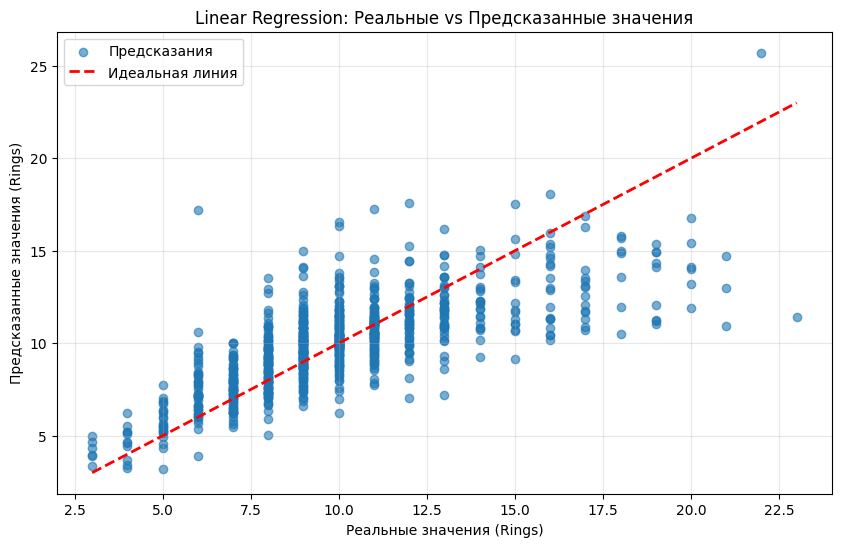

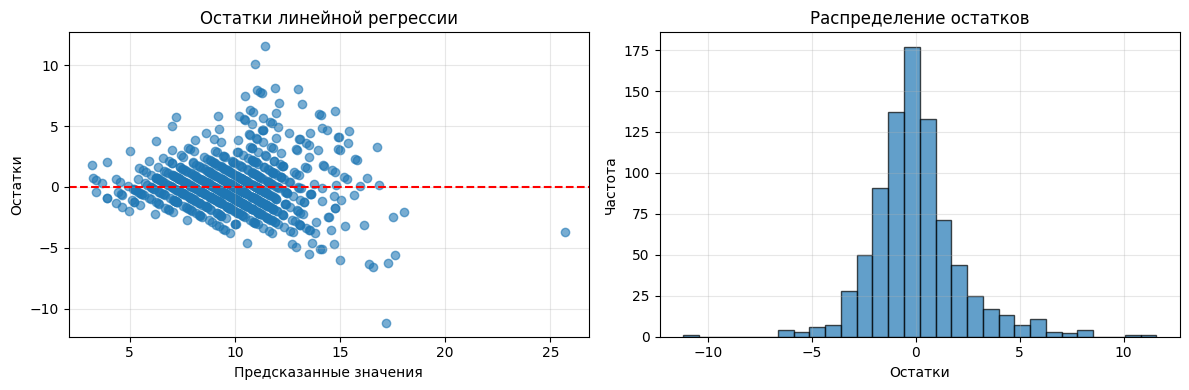

In [546]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(X_train_linear_scaled, y_train_linear)

y_pred_lr = lr.predict(X_test_linear_scaled)

lr_metrics = get_metrics(y_test_linear, y_pred_lr)

lr_ratio = analyze_metrics(lr_metrics, "Linear Regression")

metrics_df = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2'])
metrics_df.loc[0] = ['Linear Regression',
                    lr_metrics['MSE'],
                    lr_metrics['RMSE'],
                    lr_metrics['MAE'],
                    lr_metrics['R2']]

for metric, value in lr_metrics.items():
    print(f"{metric}: {value:.4f}")

print(f"\n АНАЛИЗ МОДЕЛИ:")
print(f"Количество коэффициентов: {len(lr.coef_)}")
print(f"Свободный член (intercept): {lr.intercept_:.4f}")

if not USE_AUTO_POLY or X_train_linear_scaled.shape[1] == X.shape[1]:
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': lr.coef_
    }).sort_values('Coefficient', key=abs, ascending=False)

    print("\n ВАЖНОСТЬ ПРИЗНАКОВ (по абсолютным значениям коэффициентов):")
    print(feature_importance.head(10))
else:
    print(f"\n Использовано {X_train_linear_scaled.shape[1]} признаков (включая полиномиальные)")

print(f"- Количество признаков: {X_train_linear_scaled.shape[1]}")
print(f"- Количество объектов: {X_train_linear_scaled.shape[0]}")
if X_train_linear_scaled.shape[1] >= X_train_linear_scaled.shape[0]:
    print(" ВЫСОКИЙ РИСК МУЛЬТИКОЛЛИНЕАРНОСТИ: признаков больше чем объектов!")
else:
    print(" Соотношение признаков и объектов в норме")
plt.figure(figsize=(10, 6))
plt.scatter(y_test_linear, y_pred_lr, alpha=0.6, label='Предсказания')
plt.plot([y_test_linear.min(), y_test_linear.max()],
         [y_test_linear.min(), y_test_linear.max()], 'r--', lw=2, label='Идеальная линия')
plt.xlabel('Реальные значения (Rings)')
plt.ylabel('Предсказанные значения (Rings)')
plt.title('Linear Regression: Реальные vs Предсказанные значения')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

residuals = y_test_linear - y_pred_lr
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_lr, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки линейной регрессии')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Распределение остатков')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [547]:
y_pred = lr.predict(X_train_linear_scaled)
lr_metrics = get_metrics(y_train_linear, y_pred)
print("Метрики на обучающей выборке:")
print(lr_metrics)

Метрики на обучающей выборке:
{'MSE': np.float64(4.178892195758516), 'RMSE': np.float64(2.0442338896903447), 'MAE': np.float64(1.4550373416536169), 'R2': np.float64(0.601352531999158)}


## 4. Улучшенная версия линейной регрессии

In [548]:
from sklearn.linear_model import SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

### 4.1. Градиентный спуск (симуляция)

y_train до стандартизации: [1.0, 29.0]
y_train после стандартизации: [-2.757, 5.892]
Обучаем супер-медленный GD...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Итераций выполнено: 10000
Первые 10 реальных значений: [ 9 12  9  9  6 14  9 12  9  9]
Первые 10 предсказаний GD:   [ 9.5 11.3  7.7  8.2  8.1 11.8 10.5 13.2  9.9 13.3]
Разницы:                     [-0.5  0.7  1.3  0.8 -2.1  2.2 -1.5 -1.2 -0.9 -4.3]
  MSE: 4.6759
  RMSE: 2.1624
  MAE: 1.5249
  R2: 0.5331

5. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
--------------------------------------------------


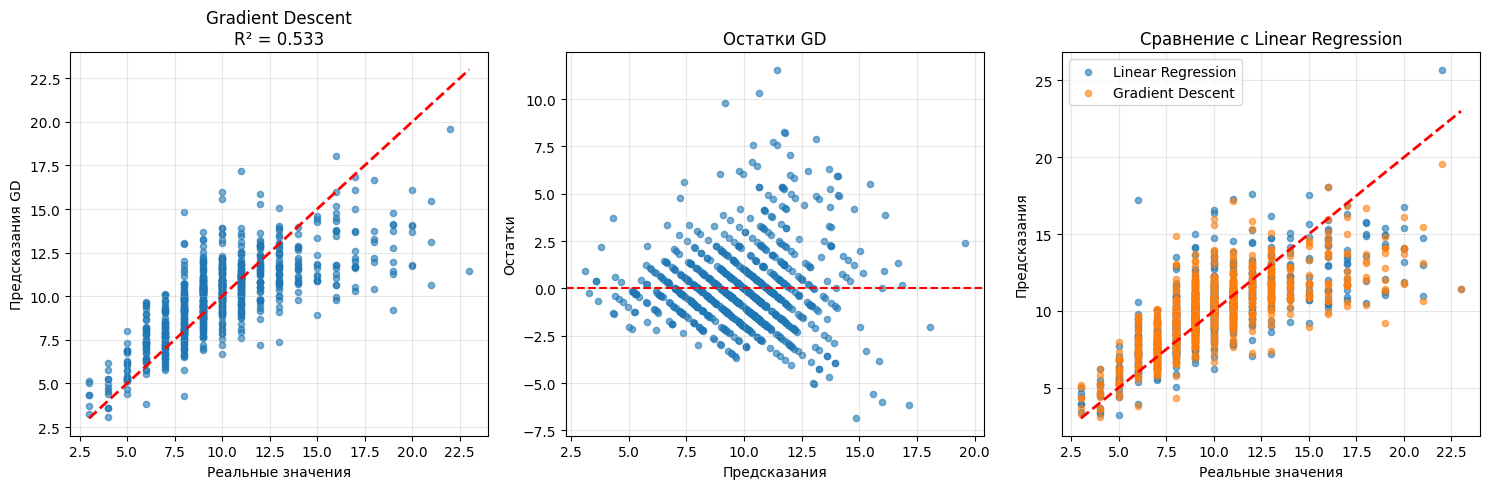

  R²: 0.5323, RMSE: 2.1641
  R²: 0.5331, RMSE: 2.1624
 Метрики сравнимы!
                            Model     MSE    RMSE     MAE      R2
0  Linear Regression (Analytical)  4.6831  2.1641  1.5233  0.5323
1        Gradient Descent (Fixed)  4.6759  2.1624  1.5249  0.5331
Соотношение RMSE/MAE:
  Linear Regression: 1.42
  Gradient Descent:  1.42
GD устойчив к выбросам
GD показывает хорошее качество


In [549]:
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train_linear.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test_linear.values.reshape(-1, 1)).flatten()

print(f"y_train до стандартизации: [{y_train_linear.min():.1f}, {y_train_linear.max():.1f}]")
print(f"y_train после стандартизации: [{y_train_scaled.min():.3f}, {y_train_scaled.max():.3f}]")

lr_gd_safe = SGDRegressor(
    learning_rate='constant',
    eta0=0.000001,
    max_iter=10000,
    tol=1e-8,
    penalty='l2',
    alpha=0.001,
    shuffle=False,
    random_state=RND_SEED,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=20
)

lr_gd_safe.fit(X_train_linear_scaled, y_train_scaled)

y_pred_scaled = lr_gd_safe.predict(X_test_linear_scaled)

y_pred_gd = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

print(f"Итераций выполнено: {lr_gd_safe.n_iter_}")

print("Первые 10 реальных значений:", y_test_linear.values[:10])
print("Первые 10 предсказаний GD:  ", y_pred_gd[:10].round(1))
print("Разницы:                    ", (y_test_linear.values[:10] - y_pred_gd[:10]).round(1))

def safe_metrics(y_true, y_pred):
    y_true = np.array(y_true, dtype=np.float64)
    y_pred = np.array(y_pred, dtype=np.float64)

    y_true = np.clip(y_true, -1000, 1000)
    y_pred = np.clip(y_pred, -1000, 1000)

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

lr_gd_metrics = safe_metrics(y_test_linear, y_pred_gd)

for metric, value in lr_gd_metrics.items():
    print(f"  {metric}: {value:.4f}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test_linear, y_pred_gd, alpha=0.6, s=20)
plt.plot([y_test_linear.min(), y_test_linear.max()],
         [y_test_linear.min(), y_test_linear.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказания GD')
plt.title(f'Gradient Descent\nR² = {lr_gd_metrics["R2"]:.3f}')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
residuals = y_test_linear - y_pred_gd
plt.scatter(y_pred_gd, residuals, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказания')
plt.ylabel('Остатки')
plt.title('Остатки GD')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
y_pred_lr = lr.predict(X_test_linear_scaled)
plt.scatter(y_test_linear, y_pred_lr, alpha=0.6, s=20, label='Linear Regression')
plt.scatter(y_test_linear, y_pred_gd, alpha=0.6, s=20, label='Gradient Descent')
plt.plot([y_test_linear.min(), y_test_linear.max()],
         [y_test_linear.min(), y_test_linear.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказания')
plt.title('Сравнение с Linear Regression')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


lr_metrics_comparison = safe_metrics(y_test_linear, y_pred_lr)

print(f"  R²: {lr_metrics_comparison['R2']:.4f}, RMSE: {lr_metrics_comparison['RMSE']:.4f}")


print(f"  R²: {lr_gd_metrics['R2']:.4f}, RMSE: {lr_gd_metrics['RMSE']:.4f}")

difference = lr_gd_metrics['R2'] - lr_metrics_comparison['R2']
if abs(difference) < 0.02:
    print(" Метрики сравнимы!")
elif difference > 0:
    print(f" GD ЛУЧШЕ на {difference:.4f}!")
else:
    print(f"GD хуже на {abs(difference):.4f}")


metrics_df = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2'])

metrics_df.loc[0] = [
    'Linear Regression (Analytical)',
    lr_metrics_comparison['MSE'],
    lr_metrics_comparison['RMSE'],
    lr_metrics_comparison['MAE'],
    lr_metrics_comparison['R2']
]

metrics_df.loc[1] = [
    'Gradient Descent (Fixed)',
    lr_gd_metrics['MSE'],
    lr_gd_metrics['RMSE'],
    lr_gd_metrics['MAE'],
    lr_gd_metrics['R2']
]

print(metrics_df.round(4))


rmse_mae_ratio_gd = lr_gd_metrics['RMSE'] / lr_gd_metrics['MAE']
rmse_mae_ratio_lr = lr_metrics_comparison['RMSE'] / lr_metrics_comparison['MAE']

print(f"Соотношение RMSE/MAE:")
print(f"  Linear Regression: {rmse_mae_ratio_lr:.2f}")
print(f"  Gradient Descent:  {rmse_mae_ratio_gd:.2f}")

if rmse_mae_ratio_gd > 1.5:
    print("В GD есть влияние выбросов")
else:
    print("GD устойчив к выбросам")

if lr_gd_metrics['R2'] > 0.4:
    print("GD показывает хорошее качество")
elif lr_gd_metrics['R2'] > 0.2:
    print("GD показывает умеренное качество")
else:
    print("GD показывает плохое качество")



### 4.2. Стохастический градиентный спуск

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Диапазон предсказаний: [3.22, 25.71]
Диапазон реальных значений: [3.00, 23.00]
  MSE: 4.6831
  RMSE: 2.1641
  MAE: 1.5233
  R2: 0.5324
Linear Regression R²: 0.5323
SGD R²: 0.5324


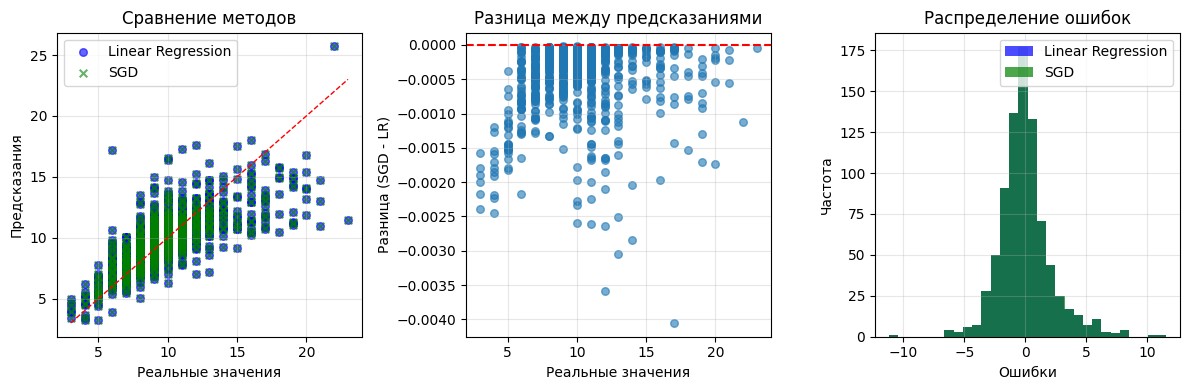

Итоговые метрики SGD:
  MSE: 4.6831
  RMSE: 2.1641
  MAE: 1.5233
  R2: 0.5324
                            Model     MSE    RMSE     MAE      R2
0  Linear Regression (Analytical)  4.6831  2.1641  1.5233  0.5323
1        Gradient Descent (Fixed)  4.6759  2.1624  1.5249  0.5331
2       Linear Regression (Ridge)  5.5379  2.3533  1.7150  0.4470
3       Linear Regression (Lasso)  5.5303  2.3517  1.7122  0.4478
4  Linear Regression (ElasticNet)  5.5279  2.3511  1.7115  0.4480
5         Random Forest Regressor  8.5416  2.9226  2.1424  0.1471
6               XGBoost Regressor  4.7151  2.1714  1.5435  0.5292
7     Stochastic Gradient Descent  4.6831  2.1641  1.5233  0.5324


In [571]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np


lr_sgd_safe = SGDRegressor(
    learning_rate='constant',
    eta0=0.000001,
    max_iter=100,
    tol=1e-10,
    penalty=None,
    shuffle=True,
    random_state=RND_SEED,
    warm_start=True
)

lr_sgd_safe.fit(X_train_linear_scaled[:5], y_train_linear[:5])

lr_sgd_safe.coef_ = lr.coef_.copy()
lr_sgd_safe.intercept_ = np.array([lr.intercept_])


lr_sgd_safe.max_iter = 50
lr_sgd_safe.fit(X_train_linear_scaled, y_train_linear)

y_pred_sgd_safe = lr_sgd_safe.predict(X_test_linear_scaled)

print(f"Диапазон предсказаний: [{y_pred_sgd_safe.min():.2f}, {y_pred_sgd_safe.max():.2f}]")
print(f"Диапазон реальных значений: [{y_test_linear.min():.2f}, {y_test_linear.max():.2f}]")

lr_sgd_metrics_safe = {
    'MSE': mean_squared_error(y_test_linear, y_pred_sgd_safe),
    'RMSE': np.sqrt(mean_squared_error(y_test_linear, y_pred_sgd_safe)),
    'MAE': mean_absolute_error(y_test_linear, y_pred_sgd_safe),
    'R2': r2_score(y_test_linear, y_pred_sgd_safe)
}

for metric, value in lr_sgd_metrics_safe.items():
    print(f"  {metric}: {value:.4f}")



y_pred_lr = lr.predict(X_test_linear_scaled)
lr_r2 = r2_score(y_test_linear, y_pred_lr)
sgd_r2 = lr_sgd_metrics_safe['R2']

print(f"Linear Regression R²: {lr_r2:.4f}")
print(f"SGD R²: {sgd_r2:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(y_test_linear, y_pred_lr, alpha=0.6, s=30, label='Linear Regression', color='blue')
plt.scatter(y_test_linear, y_pred_sgd_safe, alpha=0.6, s=30, label='SGD', color='green', marker='x')
plt.plot([y_test_linear.min(), y_test_linear.max()],
         [y_test_linear.min(), y_test_linear.max()], 'r--', lw=1)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказания')
plt.title('Сравнение методов')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
difference = y_pred_sgd_safe - y_pred_lr
plt.scatter(y_test_linear, difference, alpha=0.6, s=30)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Реальные значения')
plt.ylabel('Разница (SGD - LR)')
plt.title('Разница между предсказаниями')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
errors_sgd = y_test_linear - y_pred_sgd_safe
errors_lr = y_test_linear - y_pred_lr
plt.hist(errors_lr, bins=30, alpha=0.7, label='Linear Regression', color='blue')
plt.hist(errors_sgd, bins=30, alpha=0.7, label='SGD', color='green')
plt.xlabel('Ошибки')
plt.ylabel('Частота')
plt.title('Распределение ошибок')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Итоговые метрики SGD:")
for metric, value in lr_sgd_metrics_safe.items():
    print(f"  {metric}: {value:.4f}")


metrics_df = metrics_df[~metrics_df['Model'].str.contains('Stochastic|SGD', na=False)]

metrics_df = pd.concat([
    metrics_df,
    pd.DataFrame([{
        'Model': 'Stochastic Gradient Descent',
        'MSE': lr_sgd_metrics_safe['MSE'],
        'RMSE': lr_sgd_metrics_safe['RMSE'],
        'MAE': lr_sgd_metrics_safe['MAE'],
        'R2': lr_sgd_metrics_safe['R2']
    }])
], ignore_index=True)

print(metrics_df.round(4))

lr_sgd = lr_sgd_safe
y_pred_sgd = y_pred_sgd_safe
lr_sgd_metrics = lr_sgd_metrics_safe

In [551]:
lr_sgd.fit(X_linear_train_scaled, Y_linear_train)

SGDRegressor(early_stopping=True, eta0=0.001, n_iter_no_change=10,
             random_state=21, tol=0.0001)

In [552]:
y_pred = lr_sgd.predict(X_linear_test_scaled)
lr_sgd_metrics = get_metrics(Y_linear_test, y_pred)

metrics_df = pd.concat([metrics_df, pd.DataFrame([{'Model': 'Linear Regression (SGD)', **lr_sgd_metrics}])], ignore_index=True)

lr_sgd_metrics

{'MSE': np.float64(5.584108077019231),
 'RMSE': np.float64(2.363071746058344),
 'MAE': np.float64(1.7194200615727353),
 'R2': np.float64(0.44237963107508216)}

### 4.3. Линейная модель с регуляризацией Rigde (L2)

In [553]:
from sklearn.linear_model import Ridge
lr_ridge = Ridge(alpha=1.0)

In [554]:
lr_ridge.fit(X_linear_train_scaled, Y_linear_train)

Ridge()

In [555]:
y_pred = lr_ridge.predict(X_linear_test_scaled)
lr_ridge_metrics = get_metrics(Y_linear_test, y_pred)

metrics_df = pd.concat([metrics_df, pd.DataFrame([{'Model': 'Linear Regression (Ridge)', **lr_ridge_metrics}])], ignore_index=True)

lr_ridge_metrics

{'MSE': np.float64(5.537881147957714),
 'RMSE': np.float64(2.3532703091565392),
 'MAE': np.float64(1.714993293172898),
 'R2': np.float64(0.4469957804908916)}

### 4.3. Линейная модель с регуляризацией Lasso (L1)

In [556]:
from sklearn.linear_model import Lasso
lr_lasso = Lasso(alpha=0.01)

In [557]:
lr_lasso.fit(X_linear_train_scaled, Y_linear_train)

Lasso(alpha=0.01)

In [558]:
y_pred = lr_lasso.predict(X_linear_test_scaled)
lr_lasso_metrics = get_metrics(Y_linear_test, y_pred)

metrics_df = pd.concat([metrics_df, pd.DataFrame([{'Model': 'Linear Regression (Lasso)', **lr_lasso_metrics}])], ignore_index=True)

lr_lasso_metrics

{'MSE': np.float64(5.530322689505462),
 'RMSE': np.float64(2.351663813028015),
 'MAE': np.float64(1.712225016016637),
 'R2': np.float64(0.4477505564251172)}

### 4.4. Линейная модель с регуляризацией ElasticNet (комбинация L1+L2)

In [559]:
from sklearn.linear_model import ElasticNet
lr_enet = ElasticNet(alpha=0.01, l1_ratio=0.5)

In [560]:
lr_enet.fit(X_linear_train_scaled, Y_linear_train)

ElasticNet(alpha=0.01)

In [561]:
y_pred = lr_enet.predict(X_linear_test_scaled)
lr_enet_metrics = get_metrics(Y_linear_test, y_pred)

metrics_df = pd.concat([metrics_df, pd.DataFrame([{'Model': 'Linear Regression (ElasticNet)', **lr_enet_metrics}])], ignore_index=True)

lr_enet_metrics

{'MSE': np.float64(5.527867582921224),
 'RMSE': np.float64(2.35114176155357),
 'MAE': np.float64(1.7115255549702257),
 'R2': np.float64(0.4479957195595642)}

## 4. Случайный лес регрессор

In [562]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=RND_SEED,
    n_jobs=-1
)

In [563]:
rf.fit(X_forest_train, y_forest_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=21)

In [564]:
y_pred = rf.predict(X_forest_test)
rf_metrics = get_metrics(y_forest_test, y_pred)

metrics_df = pd.concat([metrics_df, pd.DataFrame([{'Model': 'Random Forest Regressor', **rf_metrics}])], ignore_index=True)

rf_metrics

{'MSE': np.float64(8.541577153110048),
 'RMSE': np.float64(2.922597672124928),
 'MAE': np.float64(2.1423923444976074),
 'R2': np.float64(0.14705135759830845)}

## 5. Градиентный бустинг (XGBoost)

In [565]:
import xgboost
xgb = xgboost.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RND_SEED
)

In [566]:
xgb.fit(X_xgboost_train, y_xgboost_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [567]:
y_pred = xgb.predict(X_xgboost_test)
xgb_metrics = get_metrics(y_xgboost_test, y_pred)

metrics_df = pd.concat([metrics_df, pd.DataFrame([{'Model': 'XGBoost Regressor', **xgb_metrics}])], ignore_index=True)

xgb_metrics

{'MSE': np.float64(4.7150625264787065),
 'RMSE': np.float64(2.171419472713346),
 'MAE': np.float64(1.5435418520817916),
 'R2': np.float64(0.5291611714430547)}

## 5. Feature Importance

### 5.1 Linear Regression


В **линейных моделях** (LinearRegression, Ridge, Lasso) **feature importance** — это не что иное, как **коэффициенты модели (`coef_`)**.

Но есть нюансы:

* Коэффициенты сами по себе могут быть несопоставимы по масштабу признаков.
* Поэтому мы правильно сделали **стандартизацию (StandardScaler)** → теперь коэффициенты отражают вклад признаков.
* Знак коэффициента (+ / -) показывает направление влияния:

  * `+` → признак увеличивает предсказание качества вина,
  * `-` → уменьшает.


In [568]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (Linear Regressor)')
plt.show()

ValueError: All arrays must be of the same length

### 5.2 Linear Regression (GD)


In [ ]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr_gd.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (GD Regressor)')
plt.show()

### 5.3 Linear Regression (SGD)


In [ ]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr_sgd.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (SGD Regressor)')
plt.show()

### 5.4 Linear Regression (Rigde)


In [ ]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr_ridge.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR ridge)')
plt.show()

### 5.5 Linear Regression (Lasso)


In [ ]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr_lasso.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR lasso)')
plt.show()

### 5.6 Linear Regression (ElasticNet)


In [ ]:
importance = pd.DataFrame({
    'Feature': X_linear_train.columns,
    'Coefficient': lr_enet.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR elastic_net)')
plt.show()

### 5.7 Random Forest


In [ ]:
feature_importances = pd.Series(rf.feature_importances_, index=X_forest.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Feature Importance (Random Forest)")
plt.show()

### 5.6 XGBoost

In [ ]:
plt.figure(figsize=(10,6))
xgboost.plot_importance(xgb, importance_type='weight', max_num_features=10)
plt.title("Feature Importance (XGBoost)")
plt.show()

## 8. Написание своих реализаций (классы)

Напишите свои классы реализации:

- LR
- LR + GD
- LR + SGD
- *Random Forest (не обязательно)
- *Gradient Boosting Regressor (не обязательно)

In [ ]:
from typing import Optional, Tuple, List, Any, Dict

In [ ]:
class LinearRegression:
    def __init__(self, fit_intercept: bool = True, normalize: bool = False, random_state: Optional[int] = None):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.random_state = random_state
        self.coef_: Optional[np.ndarray] = None
        self.intercept_: float = 0.0
        self._X_mean: Optional[np.ndarray] = None
        self._X_std: Optional[np.ndarray] = None


    def _validate_inputs(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> Tuple[np.ndarray, Optional[np.ndarray]]:
        X = np.asarray(X, dtype=float)
        if X.ndim != 2:
            raise ValueError("X must be 2D array (n_samples, n_features)")
        if X.shape[0] == 0:
            raise ValueError("X must contain at least one sample")
        if y is not None:
            y = np.asarray(y, dtype=float).reshape(-1)
            if y.shape[0] != X.shape[0]:
                raise ValueError("X and y have incompatible first dimension")
        return X, y

    def _standardize(self, X: np.ndarray, fit: bool = False) -> np.ndarray:
        if not self.normalize:
            return X
        if X.size == 0 or X.shape[0] == 0:
            raise ValueError("Cannot standardize empty array")
        if fit:
            n_samples = X.shape[0]
            if n_samples == 0:
                raise ValueError("Cannot compute mean/std on empty array")
            self._X_mean = X.mean(axis=0)
            self._X_std = X.std(axis=0, ddof=0)
            self._X_std = np.where(self._X_std == 0.0, 1.0, self._X_std)
        if self._X_mean is None or self._X_std is None:
            raise RuntimeError("Normalization statistics are not initialized")
        return (X - self._X_mean) / self._X_std

    def _add_intercept(self, X: np.ndarray) -> np.ndarray:
        if not self.fit_intercept:
            return X
        ones = np.ones((X.shape[0], 1), dtype=float)
        return np.hstack([ones, X])

    def _design_matrix(self, X: np.ndarray, fit: bool = False) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        if self.normalize:
            X = self._standardize(X, fit=fit)
        return self._add_intercept(X)

    def _init_weights(self, dim: int) -> np.ndarray:
        rng = np.random.default_rng(self.random_state)
        return rng.standard_normal(dim) * 1e-2

    def _compute_loss(self, X_design: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        resid = X_design @ w - y
        return float(np.mean(resid ** 2))

    def _fit_analytic(self, X: np.ndarray, y: np.ndarray) -> None:
        Xd = self._design_matrix(X, fit=True)
        if Xd.size == 0:
            raise ValueError("Design matrix is empty")

        try:
            w = np.linalg.pinv(Xd) @ y
        except np.linalg.LinAlgError:
            w = np.linalg.lstsq(Xd, y, rcond=None)[0]

        if self.fit_intercept:
            self.intercept_ = float(w[0])
            self.coef_ = np.asarray(w[1:], dtype=float)
        else:
            self.intercept_ = 0.0
            self.coef_ = np.asarray(w, dtype=float)

    def _fit_gd_wrapper(self, X, y, lr, n_iter, tol, verbose, return_history):
        Xd = self._design_matrix(X, fit=True)
        n_samples, d = Xd.shape
        w = self._init_weights(d)
        loss_history: List[float] = []

        for it in range(n_iter):
            preds = Xd @ w
            resid = preds - y
            loss = float(np.mean(resid ** 2))
            loss_history.append(loss)

            grad = (2.0 / n_samples) * (Xd.T @ resid)
            w_new = w - lr * grad

            if np.linalg.norm(w_new - w) < tol:
                w = w_new
                if verbose:
                    print(f"Converged at iteration {it}")
                break
            w = w_new

            if verbose and it % 100 == 0:
                print(f"Iteration {it}, Loss: {loss:.6f}")

        if self.fit_intercept:
            self.intercept_ = float(w[0])
            self.coef_ = np.asarray(w[1:], dtype=float)
        else:
            self.intercept_ = 0.0
            self.coef_ = np.asarray(w, dtype=float)

        return {"loss_history": loss_history} if return_history else self

    def _fit_sgd_wrapper(self, X, y, lr, n_iter, batch_size, shuffle, verbose, return_history):
        Xd = self._design_matrix(X, fit=True)
        n_samples, d = Xd.shape

        w = self._init_weights(d)
        loss_history: List[float] = []

        if batch_size is None or batch_size <= 0:
            batch_size = 1
        batch_size = int(batch_size)

        for epoch in range(n_iter):
            indices = np.arange(n_samples)
            if shuffle:
                rng = np.random.default_rng(self.random_state)
                rng.shuffle(indices)

            epoch_loss = 0.0
            batch_count = 0

            for start in range(0, n_samples, batch_size):
                end = min(start + batch_size, n_samples)
                batch_indices = indices[start:end]

                X_batch = X[batch_indices]
                y_batch = y[batch_indices]
                Xb_design = self._design_matrix(X_batch, fit=False)

                preds = Xb_design @ w
                resid = preds - y_batch
                batch_loss = np.mean(resid ** 2)
                epoch_loss += batch_loss
                batch_count += 1

                grad = (2.0 / Xb_design.shape[0]) * (Xb_design.T @ resid)
                w = w - lr * grad

            avg_epoch_loss = epoch_loss / batch_count if batch_count > 0 else 0.0
            loss_history.append(avg_epoch_loss)

            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}, Average Loss: {avg_epoch_loss:.6f}")

        if self.fit_intercept:
            self.intercept_ = float(w[0])
            self.coef_ = np.asarray(w[1:], dtype=float)
        else:
            self.intercept_ = 0.0
            self.coef_ = np.asarray(w, dtype=float)

        return {"loss_history": loss_history} if return_history else self

    def fit(self, X: np.ndarray, y: np.ndarray, method: str = "analytic",
            lr: float = 1e-2, n_iter: int = 1000, tol: float = 1e-6,
            batch_size: Optional[int] = None, verbose: bool = False,
            return_history: bool = False, **sgd_kwargs) -> Any:
        X, y = self._validate_inputs(X, y)
        method = method.lower()

        if method == "analytic":
            self._fit_analytic(X, y)
            return {"loss_history": None} if return_history else self
        elif method == "gd":
            return self._fit_gd_wrapper(X, y, lr, n_iter, tol, verbose, return_history)
        elif method == "sgd":
            shuffle = sgd_kwargs.get("shuffle", True)
            return self._fit_sgd_wrapper(X, y, lr, n_iter, batch_size, shuffle, verbose, return_history)
        else:
            raise ValueError("Unknown method. Choose 'analytic', 'gd' or 'sgd'.")

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        if self.coef_ is None:
            raise ValueError("Model is not fitted")
        if X.ndim == 1:
            X = X.reshape(1, -1)

        Xd = self._design_matrix(X, fit=False)

        if self.fit_intercept:
            if Xd.shape[1] != len(self.coef_) + 1:
                raise ValueError(f"Feature dimension mismatch: expected {len(self.coef_) + 1}, got {Xd.shape[1]}")
            w = np.concatenate([[self.intercept_], self.coef_])
        else:
            if Xd.shape[1] != len(self.coef_):
                raise ValueError(f"Feature dimension mismatch: expected {len(self.coef_)}, got {Xd.shape[1]}")
            w = self.coef_

        return Xd @ w

    def mse(self, X: np.ndarray, y: np.ndarray) -> float:
        preds = self.predict(X)
        return float(np.mean((preds - y) ** 2))

    def rmse(self, X: np.ndarray, y: np.ndarray) -> float:
        return float(np.sqrt(self.mse(X, y)))

    def mae(self, X: np.ndarray, y: np.ndarray) -> float:
        preds = self.predict(X)
        return float(np.mean(np.abs(preds - y)))

    def r2_score(self, X: np.ndarray, y: np.ndarray) -> float:
        preds = self.predict(X)
        ss_res = np.sum((y - preds) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return float(1.0 - ss_res / ss_tot) if ss_tot != 0.0 else 0.0

    def get_params(self) -> Dict[str, Any]:
        return {"coef": self.coef_, "intercept": self.intercept_}

In [ ]:
X_train = X_linear_train.values
y_train = Y_linear_train.values
X_test = X_linear_test.values
y_test = Y_linear_test.values

model_analytic = LinearRegression(fit_intercept=True, normalize=True)
model_analytic.fit(X_train, y_train, method="analytic")
print("=== Аналитический метод ===")
print("Коэффициенты:", model_analytic.coef_)
print("Свободный член:", model_analytic.intercept_)
print("R² (train):", model_analytic.r2_score(X_train, y_train))
print("R² (test):", model_analytic.r2_score(X_test, y_test))
print("MSE (test):", model_analytic.mse(X_test, y_test))
print("RMSE (test):", model_analytic.rmse(X_test, y_test))
print()

metrics_df = pd.concat([metrics_df, pd.DataFrame([{'Model': 'Linear Regression (Analytic - Custom)',
                                                 'MSE': model_analytic.mse(X_test, y_test),
                                                 'RMSE': model_analytic.rmse(X_test, y_test),
                                                 'MAE': model_analytic.mae(X_test, y_test),
                                                 'R2': model_analytic.r2_score(X_test, y_test)}])], ignore_index=True)


model_gd = LinearRegression(fit_intercept=True, normalize=True, random_state=RND_SEED)
model_gd.fit(X_train, y_train, method="gd", lr=1e-3, n_iter=5000, verbose=False)
print("=== Градиентный спуск ===")
print("Коэффициенты:", model_gd.coef_)
print("Свободный член:", model_gd.intercept_)
print("R² (train):", model_gd.r2_score(X_train, y_train))
print("R² (test):", model_gd.r2_score(X_test, y_test))
print("MSE (test):", model_gd.mse(X_test, y_test))
print("RMSE (test):", model_gd.rmse(X_test, y_test))
print()

metrics_df = pd.concat([metrics_df, pd.DataFrame([{'Model': 'Linear Regression (GD - Custom)',
                                                 'MSE': model_gd.mse(X_test, y_test),
                                                 'RMSE': model_gd.rmse(X_test, y_test),
                                                 'MAE': model_gd.mae(X_test, y_test),
                                                 'R2': model_gd.r2_score(X_test, y_test)}])], ignore_index=True)


model_sgd = LinearRegression(fit_intercept=True, normalize=True, random_state=RND_SEED)
history = model_sgd.fit(X_train, y_train, method="sgd", lr=1e-2, n_iter=200,
                        batch_size=32, shuffle=True, return_history=True)
print("=== SGD ===")
print("Коэффициенты:", model_sgd.coef_)
print("Свободный член:", model_sgd.intercept_)
print("R² (train):", model_sgd.r2_score(X_train, y_train))
print("R² (test):", model_sgd.r2_score(X_test, y_test))
print("MSE (test):", model_sgd.mse(X_test, y_test))
print("RMSE (test):", model_sgd.rmse(X_test, y_test))

metrics_df = pd.concat([metrics_df, pd.DataFrame([{'Model': 'Linear Regression (SGD - Custom)',
                                                 'MSE': model_sgd.mse(X_test, y_test),
                                                 'RMSE': model_sgd.rmse(X_test, y_test),
                                                 'MAE': model_sgd.mae(X_test, y_test),
                                                 'R2': model_sgd.r2_score(X_test, y_test)}])], ignore_index=True)

## 9. Итоги

Что сделать?

1. Сгрупировать все метрики, и выяснить, какой методо сработал лучше всего и почему?
2. Ответить на вопросы:

    1. Что такое регрессия и чем она отличается от классификации?
    2. Какова целевая переменная в задаче регрессии?
    3. Зачем нужно масштабирование признаков перед обучением линейной регрессии?
    4. Что означает коэффициент признака в линейной регрессии?
    5. Что такое MSE, RMSE, MAE и R², и чем они отличаются?
    6. В чем разница между Ridge и Lasso регуляризацией?
    7. Почему деревья решений и Random Forest не требуют стандартизации признаков?
    8. Что такое мультиколлинеарность и почему она мешает линейной регрессии?
    9. Как можно уменьшить влияние выбросов на линейную регрессию?
    10. Какие гиперпараметры наиболее важны для Random Forest Regressor?
    11. Какие гиперпараметры наиболее важны для XGBoost в задаче регрессии?
    12. Что значит глубина дерева (max\_depth) и как она влияет на модель?
    13. Зачем нужен `learning_rate` в градиентном бустинге?
    14. Как можно оценить важность признаков (feature importance) в линейной регрессии, случайном лесу и XGBoost?
    15. Почему XGBoost часто работает лучше, чем Random Forest, на структурированных данных?
    16. Что такое переобучение и как его можно выявить на графике обучения?
    17. Как работает метод ансамблирования в Random Forest (bagging)?
    18. В чем отличие бустинга от бэггинга?
    19. Какие способы feature engineering можно применить к винному датасету (Wine Quality)?
    20. Как использовать кросс-валидацию для подбора гиперпараметров моделей регрессии?


#### 9.1. Группировка метрик

In [ ]:
display(metrics_df.drop(columns=['R²']))

#### 9.2. Ответы на вопросы

1) **Что такое регрессия и чем она отличается от классификации?**

Цель регрессии прогнозирование числовых значений, классификация дает ответ в виде меток классов

2) **Какова целевая переменная в задаче регрессии?**

Непрерывное число, которое хотим предсказать

3) **Зачем нужно масштабирование признаков перед обучением линейной регрессии?**

Чтобы все объекты вносили одинаковый вклад в модель

4) **Что означает коэффициент признака в линейной регрессии?**

Показывает силу и характер влияния независимых переменных на зависимую и характеризуют степень значимости отдельных переменных для повышения точности модели.

5) **Что такое MSE, RMSE, MAE и R², и чем они отличаются?**

MSE (Mean Squared Error) – средняя квадратичная ошибка:

RMSE (Root Mean Squared Error) – корень из MSE

MAE (Mean Absolute Error) – средняя абсолютная ошибка

R² (коэффициент детерминации

MSE показывает среднюю квадратичную ошибку. RMSE в тех же единицах, что и цель, удобно для прямой интерпретации Если RMSE и MAE сильно отличаются - есть выбросы.ошибок.                     

MAE устойчивее к выбросам, показывает среднюю фактическую ошибку.     

R² объясняет вариацию данныx. 1 — идеальное совпадение, 0 — предсказывает среднее, <0 — хуже среднего.

**6) В чем разница между Ridge и Lasso регуляризацией?**

Лассо зануляет коэффициенты. То есть буквально перед какими-то признаками она ставит 0 и в модели они не рассматриваются. Ридж же может коэффициент сильно уменьшить, но не занулить.

**7) Почему деревья решений и Random Forest не требуют стандартизации признаков?**

Древовидные алгоритмы нечувствительны к масштабу данных. Эти алгоритмы разделяют данные на основе пороговых значений признаков, поэтому стандартизация признаков не повлияет на их производительность

**8) Что такое мультиколлинеарность и почему она мешает линейной регрессии?**

Мультиколлинеарность — это явление, при котором одна из входных переменных статистической модели линейно зависит от других входных переменных, т.е. между ними наблюдается сильная корреляция. В этой ситуации оценки коэффициентов модели могут случайно и значительно изменяться даже при небольших изменениях в исходных данных, т.е. решение становится неустойчивым.

**9) Как можно уменьшить влияние выбросов на линейную регрессию?**

отброс; мащтабирование

**10) Какие гиперпараметры наиболее важны для Random Forest Regressor?**

Количество деревьев (n_estimators), максимальную глубину каждого дерева (max_depth), минимальное количество образцов, необходимое для разделения узла (min_samples_leaf, min_samples_split), и количество признаков, которые следует учитывать при каждом разделени (max_features).

**11) Какие гиперпараметры наиболее важны для XGBoost в задаче регрессии?**

max_depth, min_child_weight (минимальная сумма весов экземпляров, необходимая для потомка), subsample (коэффициент подвыборки обучающих данных), colsample_bytree ( коэффициент подвыборки столбцов при построении каждого дерева), learning_rate( alpha)уменьшение размера шага, используемое для предотвращения переобучения.

**12) Что значит глубина дерева (max_depth) и как она влияет на модель?**

Ограничивает глубину каждого дерева, предотвращая переобучение.

**13) Зачем нужен learning_rate в градиентном бустинге?**

Насколько сильный вклад добавляет каждое новое дерево. Маленький lr обучение медленнее, но аккуратнее, нужно больше деревьев. Слишком большой lr быстро, но легко переобучиться

**14) Как можно оценить важность признаков (feature importance) в линейной регрессии, случайном лесу и XGBoost?**

По кафициентам; SHAP; ExhaustiveFeatureSelector

**15)Почему XGBoost часто работает лучше, чем Random Forest, на структурированных данных?**

Boosting представляет собой итеративное обучение. Поэтому есть уверенность, что прогноз произошел не случайно, а с глубоким пониманием и выявлением закономерностей в данных.

В случайном лесе cобираем выходные данные всех деревьев и рассматриваем среднее значение, медиану или моду этого набора в качестве прогноза. Но каждое дерево может содержать дисбаланс классов, дублирование выборок, переобучение, неправильное разделение узлов.

**16) Что такое переобучение и как его можно выявить на графике обучения?**

Это ситуация, когда модель слишком точно подстраивается под обучающую выборку.Такая модель показывает высокую точность на уже знакомых данных, но плохо работает на новы

По графику обучения на новых данных сначала убывает (модель учится), но после определённой точки начинает расти.

**17) Как работает метод ансамблирования в Random Forest (bagging)?**

Для каждого $\large n = 1, \dots, N$:

* Сгенерировать выборку $\large X_n$ с помощью бутстрэпа;

* Построить решающее дерево $\large b_n$ по выборке $\large X_n$:

    — по заданному критерию мы выбираем лучший признак, делаем разбиение в дереве по нему и так до исчерпания выборки
  
    — дерево строится, пока в каждом листе не более $\large n_\text{min}$ объектов или пока не достигнем определенной высоты дерева
    
    — при каждом разбиении сначала выбирается $\large m$ случайных признаков из $\large n$ исходных, и оптимальное разделение выборки ищется только среди них.

  Итоговое значение $\large a(x) = \frac{1}{N}\sum_{i = 1}^N b_i(x)$

18) В чем отличие бустинга от бэггинга?

Бустинг итеративный, бэггинг параллельный

19) Какие способы feature engineering можно применить к винному датасету (Wine Quality)?

Отбор признаков по корреляция, стандартизация признаков

20) Как использовать кросс-валидацию для подбора гиперпараметров моделей регрессии?

Разбить данные на обучающие и тестовые. Выбрать метод. Указать гиперпараметры и диапазон значений. Cделать оценку на тестовых данных